In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc

%matplotlib inline

In [2]:
train = pd.read_csv('data/train_final.csv', delimiter='\t')
playlists = pd.read_csv('data/playlists_final.csv', delimiter='\t')
target_playlists = pd.read_csv('data/target_playlists.csv', delimiter='\t')
target_tracks = pd.read_csv('data/target_tracks.csv', delimiter = '\t')
tracks = pd.read_csv('data/tracks_final.csv', delimiter='\t')

In [3]:
train.head()

,playlist_id,track_id
0,3271849,2801526
1,5616275,727878
2,11267488,2805283
3,10103900,1515105
4,3836898,2945623


In [4]:
playlists.head()

,created_at,playlist_id,title,numtracks,duration,owner
0,1216545588,644838,[12727],27,6522,41504
1,1249326867,7577564,[],9,2650,41504
2,1257766688,3120683,[183],16,3645,44542
3,1248079275,4278112,"[12389, 18698, 18925, 11695, 7117]",15,4151,44542
4,1175201268,8656823,"[12809, 2095, 13257, 12671, 20426, 14448, 18698]",84,18414,44542


In [5]:
playlists.numtracks.describe()

count    57561.000000
mean        30.738816
std         42.731612
min          0.000000
25%          5.000000
50%         13.000000
75%         36.000000
max        200.000000
Name: numtracks, dtype: float64

In [6]:
playlists.duration.describe()

count     57561.000000
mean       8079.101075
std       11852.823672
min           0.000000
25%        1260.000000
50%        3359.000000
75%        9224.000000
max      439332.000000
Name: duration, dtype: float64

In [7]:
playlists.groupby('owner').count()['created_at'].describe()

count    15264.000000
mean         3.771030
std         11.327855
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max       1158.000000
Name: created_at, dtype: float64

In [8]:
tracks.head()

,track_id,artist_id,duration,playcount,album,tags
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]"
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]"
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]"
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]"
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]"


In [9]:
len(tracks.album.unique())

27606

In [10]:
tracks['duration'].describe()

count    1.000000e+05
mean     2.620218e+05
std      9.864639e+05
min     -1.000000e+00
25%      1.970000e+05
50%      2.400000e+05
75%      2.970000e+05
max      2.195850e+08
Name: duration, dtype: float64

In [11]:
tracks['playcount'].describe()

count    9.910600e+04
mean     2.494978e+03
std      1.083555e+04
min      0.000000e+00
25%      7.300000e+01
50%      4.910000e+02
75%      2.067000e+03
max      1.918184e+06
Name: playcount, dtype: float64

In [12]:
tracks.groupby('artist_id').count()['track_id'].describe()

count    17536.000000
mean         5.702555
std         10.732867
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        221.000000
Name: track_id, dtype: float64

In [13]:
tracks['playcount'].describe()

count    9.910600e+04
mean     2.494978e+03
std      1.083555e+04
min      0.000000e+00
25%      7.300000e+01
50%      4.910000e+02
75%      2.067000e+03
max      1.918184e+06
Name: playcount, dtype: float64

In [14]:
target_playlists.head()

,playlist_id
0,10024884
1,10624787
2,4891851
3,4267369
4,65078


In [15]:
target_tracks.head()

,track_id
0,1316175
1,3885714
2,3091270
3,226759
4,230596


In [16]:
playlists.apply(lambda x : len(x['title'].split(',')), axis=1).max()

30

In [17]:
pd.unique(train['playlist_id']).size

45649

In [18]:
pd.unique(train['track_id']).size

99999

In [19]:
density = len(train) / (99999 * 45649)
density

0.00022794199332385227

In [20]:
len(tracks)

100000

In [21]:
len(target_tracks)

32195

In [22]:
s = set(target_tracks['track_id'])
s2 = set(tracks['track_id'])
pl = set(target_playlists['playlist_id'])
pl2 = set(playlists['playlist_id'])

In [23]:
all(x in pl2 for x in pl)

True

In [24]:
playlists['numtrack_token'] = pd.qcut(playlists['numtracks'], 6)

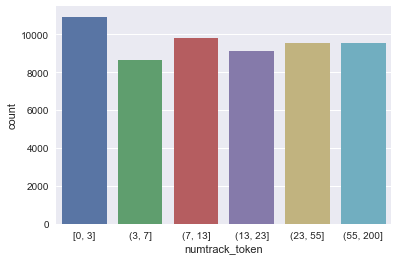

In [25]:
sns.countplot(x = 'numtrack_token', data=playlists)

In [26]:
empty_playlists = playlists[playlists['numtracks'] == 0]

In [27]:
len(empty_playlists)

1173

In [28]:
playlists['created_at'].min()

1169657433

In [29]:
playlists['created_at'].max()

1423786569

In [30]:
(1423786569 - 1169657433) / 1000 / (60 * 60)

70.59142666666666

In [31]:
a = train[train['playlist_id'] == 11397138]
b = a['track_id'].values
sum([x['duration'] for _,x in tracks.iterrows() if x['track_id'] in b])

4577999

In [32]:
def check_playlist(playlist_id):
    """ Checks if the total duration of the playlist is always >= of the sum of the durations of all the tracks
        in the playlist. """
    duration = int(playlists[playlists['playlist_id'] == playlist_id]['duration'])
    pl_tracks = train[train['playlist_id'] == playlist_id]
    track_ids = pl_tracks['track_id'].values
    
    sum_duration = sum([x['duration'] for _,x in tracks.iterrows() if x['track_id'] in track_ids])
    return sum_duration/1000 <= duration

In [33]:
all(check_playlist(t['playlist_id']) for _,t in playlists.sample(10).iterrows())

True

In [34]:
playlists

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token
0,1216545588,644838,[12727],27,6522,41504,"(23, 55]"
1,1249326867,7577564,[],9,2650,41504,"(7, 13]"
2,1257766688,3120683,[183],16,3645,44542,"(13, 23]"
3,1248079275,4278112,"[12389, 18698, 18925, 11695, 7117]",15,4151,44542,"(13, 23]"
4,1175201268,8656823,"[12809, 2095, 13257, 12671, 20426, 14448, 18698]",84,18414,44542,"(55, 200]"
5,1224952363,10961458,"[7194, 3225, 9438, 13502, 11695]",32,6441,44542,"(23, 55]"
6,1171573001,5527068,[19505],44,13776,40796,"(23, 55]"
7,1220175946,2940714,[12323],69,18214,40796,"(55, 200]"
8,1181710641,11397138,[],27,8466,44467,"(23, 55]"
9,1181710641,3128020,"[12111, 4776, 14448]",89,30451,44467,"(55, 200]"


In [40]:
import utility

FileNotFoundError: File b'../data/train_final.csv' does not exist